# **Problem Being Solved**

 
Consider a 10-year equity-linked contract issued to a life aged 60, with a single premium of 
$P = \text{MK } 10000$. After a deduction of 3\% for initial expenses, the premium is invested in an equity fund. 
An annual management charge of 0.5\% is deducted from the fund at the start of every year except the first.

1) The contract carries a guarantee that the maturity benefit will not be less than the single premium, \(P\).
2) The risk-free rate of interest is 5\% per year, continuously compounded, and the stock price volatility is 25\% per year.
	 
	
Assume that the policy is still in force six years after it was issued to a life aged 60. 
Assuming there are no lapses, calculate the contribution to the reserve from the GMMB at this time, 
given that since the policy was purchased, the value of the stock has
	
	 
a) increased by 45\%, and  
b) increased by 5\%.
Use both the closed-form solution and the Monte Carlo method in Python.
 
**Hints:**
Modify the code from Example 1.6. Test it using Example 14.2 in Dickson, page 438.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# **Exact Solution Definition**

Makeham's law is given by $\mu_x=A+Bc^x$. The closed form for ${_{t}p_{x}}$ is given by (Dickson, p.38)
 \begin{equation}
 {_{t}p_{x}}= \exp \left(-tA-\frac{Bc^{x}(c^t-1)}{\log (c)}\right).
 \end{equation}
 In general (Dickson, p.23),

In [2]:
def tpx(t, A, B, c, x):
  z1=-t*A-(B*c**x*(c**t-1))/(np.log(c))
  z2=np.exp(z1)
  return z2

# **Monte Carlo**

We apply the Monte Carlo method as described on page 8 of the paper:

_Luengo, D., Martino, L., Bugallo, M., Elvira, V., & Särkkä, S. (2020). A survey of Monte Carlo methods for parameter estimation. EURASIP Journal on Advances in Signal Processing, 2020(1), 25._

In this case, $\mu_x=A+Bc^x$, we evaluate $\int_{0}^{t} \mu_{x+s}\,ds$ using Monte Carlo integration as follows:
\begin{align}
 \int_{0}^{t} \mu_{x+s}\,ds &= \int_{0}^{t} \frac{f(s)}{f(s)} \mu_{x+s}\,ds \\
 &= \int_{0}^{t} \frac{\mu_{x+s}}{f(s)}f(s) \,ds \\
 &= \mathbb{E} \left(\frac{\mu_{x+s}}{f(s)}\right) \\
 & \approx \frac{1}{N} \sum_{i=1}^{N}\frac{\mu_{x+s_i}}{f(s_i)}
\end{align}

We assume that $s_i \sim \mathcal{U}(0,t)$. That is, $f(s)=\tfrac{1}{t}$.

In [3]:
def Mont1(t,A,B,c,N, x):
  U=np.random.uniform(0,1,N)
  Uab=0+(t-0)*U
  mu1=A+B*c**(x+Uab)
  kern=1/t
  z=np.mean(mu1/kern) #Monte Carlo Integration
  return np.exp(-z)

# **Testing Initial Code**

In [4]:
N=10000
t0=0
t2=10
t=t2-t0
x=60
A, B, c = 0.0001, 0.00035, 1.075

print(Mont1(t,A,B,c,N, x))
print(tpx(t, A, B, c, x))

0.6739806495940075
0.6739576751262345


# **Estimating Confidence Interval**

In excel, you can use the formula =NORM.INV(1-B1/2,0,1), given that in cell B1 you have written values like 0.05, 0.01, and 0.10 etc. This calculation can give you values like 1.64, 1.96, 2.576, etc. These values are for the 90\%, 95 \% and 99 \% confidence intervals. Please get these values using Ms-Excel.

In [5]:
Zs90, Zs95, Zs99=1.64, 1.96, 2.756
Niter=300
iter=0
Vec=np.zeros(Niter)
while iter<Niter:
  Vec[iter]= Mont1(t,A,B,c,N, x)
  np.random.seed(iter) # We are Varying random paths here
  iter +=1

probability is 0.6739968476663645 with 95 % CI [0.6728435086927138, 0.6751501866400151]


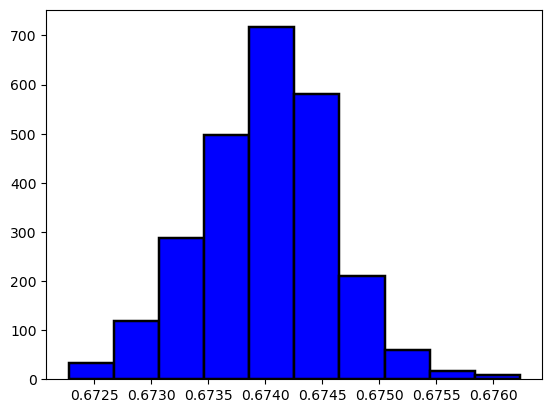

In [6]:
plt.hist(Vec, facecolor="blue", edgecolor="black", density=True,linewidth=1.79)
tpxest=np.mean(Vec)
sigma1=np.std(Vec)
CI=[tpxest-Zs95*sigma1, tpxest+Zs95*sigma1]
print(f"probability is {tpxest} with 95 % CI {CI}")

# **Estimating Prices, assuming Minimal Noise**
This means, we will estimate both probability and price via deterministic method/ closed forms.

The contribution to the reserve at time $t$, where $0 \leq t \leq N$, for the GMMB--assuming the contract remains in force at time \(t\)--is given by the value of the option at time \(t\):
	\begin{equation}
	\pi(t) = P \; {_{N-t}p_{x+t}} \Big[ e^{-r(N-t)} \Phi(-d_2(t)) - \xi \, S_t \Phi(-d_1(t)) \Big],
	\end{equation}
	where
	\begin{align*}
		d_1(t) &= \frac{\log(\xi S_t) + \left(r_t + \tfrac{\sigma^2}{2}\right)(N-t)}{\sigma \sqrt{N-t}},\\
		d_2(t) &= d_1(t) - \sigma \sqrt{N-t},\\
		\xi &= (1-e)(1-m)^{N-1}.
	\end{align*}


**Example:** Consider a 10-year equity-linked contract issued to a life aged
60, with a single premium of $ P $ = MK 18 million kwacha. After a deduction of 3\% for initial
expenses, the premium is invested in an equity fund. An annual management 
charge of 0.5\% is deducted from the fund at the start of every year except the first.
 
 
1) The contract carries a guarantee that the maturity benefit will not be less than
	the single premium, $ P $.
2) The risk free rate of interest is 5\% per year, continuously compounded, and
	stock price volatility is 25\% per year.

In [7]:
def PhiEst(x):
    zx=0.5*(1+math.erf(x/math.sqrt(2)))
    return zx 
def Ds(Xi, rt, sigma2, N, St, t):
    d1=(np.log(Xi*St)+(rt+sigma2**2/2)*(N-t))/(sigma2*np.sqrt(N-t))
    d2=d1-sigma2*np.sqrt(N-t)
    return d1, d2

In [8]:
e=3/100
m=0.5/100
St=1.45  #Question number (a)


Nt2=10
t0=6
Xi=(1-e)*(1-m)**(Nt2-1)
print(f"The value of Xi is {Xi}")
rt=5/100
sigma2=25/100
P=10000
d1, d2= Ds(Xi, rt, sigma2, Nt2, St,t0)
print(f"The value of d_1(6) is {d1}")
print(f"The value of d_2(6) is {d2}")
prob=tpx(t-t0, A, B, c, x+t0)
print(f"Survival probability is {prob}")
Price=P*prob*(np.exp(-rt*(Nt2-t0))*PhiEst(-d2)-Xi*St*PhiEst(-d1))
print(f"Contributions to reserve are {np.round(Price,2)} million kwacha in the {t0}th year")

The value of Xi is 0.9272128910068328
The value of d_1(6) is 1.2419829450717517
The value of d_2(6) is 0.7419829450717517
Survival probability is 0.8249346303425563
Contributions to reserve are 358.92 million kwacha in the 6th year


# **Monte Carlo Method**

The basic mean value Monte Carlo method simply says that $ \displaystyle  \mathbb{E} (g(w)) \approx \frac{\sum _{i=1}^{M}g(s_i)}{M}$. You remember that the strong law of large numbers says that $\mathbb{P} \left( \displaystyle \mathbb{E} (g(w)) = \lim_{M\to \infty} \frac{\sum _{i=1}^{M}g(s_i)}{M}\right)=1$. I request leader to understand what is being meant here. Read chapter 11 of the book ``Introduction to Probability Models'' by Sheldon Ross (2009) for more details.

In our case we assume that $S_N$ follows a lognormal distribution. This means, we can simulate $S_N$ by the following Geometric Brownian Motion (GBM):
\begin{equation}
S_N=S_t \exp \left[ \left(r-\frac{\sigma^2}{2} \right)(N-t)+ \sigma \sqrt{N-t} N(0,1)\ \right]
\end{equation}
Thus, we can then apply Monte Carlo method as follows: $$\pi (t)=P \; \xi \; {_{N}p_{x}} \; \mathbb{E}^{\mathbb{Q}} \!\left(e^{-r(N-t)}(\xi^{-1}-S_{N})^{+}\right) \approx P \; \xi \; {_{N}p_{x}} \;    \frac{\sum _{i=1}^{M} \!\left(e^{-r(N-t)}(\xi^{-1}-S_{N_i})^{+}\right)}{M}$$

In [9]:
St=1.45
nt=6
N01=np.random.randn(N)
#print(np.mean(N01), np.std(N01))
SN=St*np.exp((rt-sigma2**2/2)*(Nt2-nt)+sigma2*np.sqrt(Nt2-nt)*N01)
hn=np.maximum(1/Xi-SN,0)
print(hn)
Pricemont=P*Xi*prob*np.mean( np.exp(-rt*(Nt2-nt))*hn)
print(Pricemont)

[0.         0.41364339 0.         ... 0.05599783 0.18833656 0.        ]
352.16078449921014


In [10]:
Niter2=300
iter2=0
Vec2=np.zeros(Niter2)
while iter2<Niter2:
    N01=np.random.randn(N)
    SN=St*np.exp((rt-sigma2**2/2)*(Nt2-nt)+sigma2*np.sqrt(Nt2-nt)*N01)
    hn=np.maximum(1/Xi-SN,0)
    Pricemont=P*Xi*prob*np.mean( np.exp(-rt*(Nt2-nt))*hn)
    Vec2[iter2]=Pricemont
    iter2 +=1

Contribution to reserves are 358.4234802225172 with 95 % CI [342.6637628381373, 374.18319760689707]


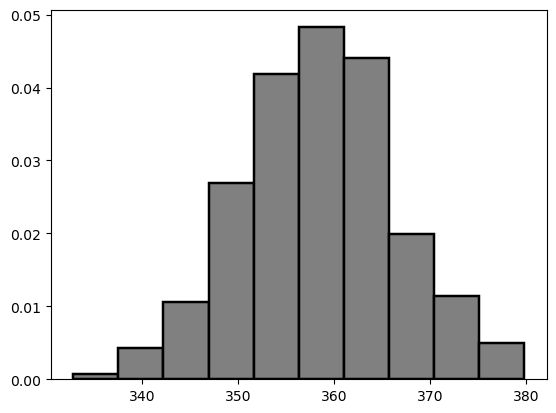

In [11]:
plt.hist(Vec2, facecolor="grey", edgecolor="black", density=True,linewidth=1.79)
cest=np.mean(Vec2)
sigma3=np.std(Vec2)
CI2=[cest-Zs95*sigma3, cest+Zs95*sigma3]
print(f"Contribution to reserves are {cest} with 95 % CI {CI2}")